In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

In [16]:
import os
os.chdir("C:\\Users\\jeeva\\Desktop\\Git Practise\\Hear_disease\\")

In [17]:
df = pd.read_csv("heart_data.csv")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [18]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cat_columns = ['HeartDisease',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'Sex',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

for col in cat_columns:
    df[col] = le.fit_transform(df[col])



In [20]:
df.drop(columns=['Race'],axis=1,inplace=True)

In [21]:
age_cat= {
    '18-24':0,'25-29':1,'30-34':1,'35-39':1,
    '40-44':2,'45-49':2,'50-54':2,'55-59':3,
    '60-64':3,'65-69':3,'70-74':4,'75-79':4,'80 or older':4
}
df['AgeCategory'] = df['AgeCategory'].replace(age_cat)

print(df['AgeCategory'].unique())

[3 4 2 0 1]


In [22]:
df['BMI'] = np.log(df['BMI']) 

In [23]:
df.drop(columns=['BMI','GenHealth','SleepTime','MentalHealth','AlcoholDrinking','Asthma','PhysicalActivity'],inplace=True)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [25]:
from sklearn.utils import resample

# separate majority and minority classes
majority = df[df.HeartDisease == 0]
minority = df[df.HeartDisease == 1]

# oversample the minority class
minority_oversampled = resample(minority,
                                replace=True,
                                n_samples=len(majority),
                                random_state=42)

# combine majority class with oversampled minority class
oversampled_data = pd.concat([majority, minority_oversampled])

# check the distribution of undersampled and oversampled datasets
oversampled_distribution = oversampled_data.HeartDisease.value_counts()

oversampled_distribution

HeartDisease
0    274456
1    274456
Name: count, dtype: int64

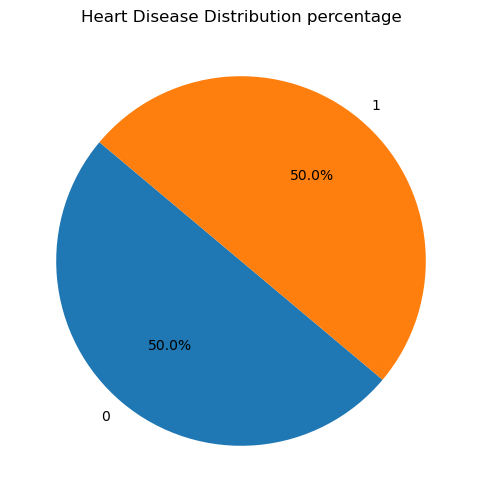

In [26]:
# Count the occurrences of each category
category_counts = oversampled_data['HeartDisease'].value_counts()

# Extract labels and sizes for the pie plot
labels = category_counts.index.tolist()
sizes = category_counts.values.tolist()

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Heart Disease Distribution percentage')
plt.show()

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# drop 'Policy_id' column from the data
#oversampled_data = oversampled_data.drop('policy_id', axis=1)

# prepare the oversampled data
X_oversampled = oversampled_data.drop('HeartDisease', axis=1)
y_oversampled = oversampled_data['HeartDisease']

# encoding categorical columns
X_oversampled_encoded = X_oversampled.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)

# splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_oversampled_encoded, y_oversampled, test_size=0.3, random_state=42)

# create and train the Random Forest model
rf_model_oversampled = RandomForestClassifier(random_state=42)
rf_model_oversampled.fit(X_train, y_train)

# predictions
y_pred = rf_model_oversampled.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74     82290
           1       0.74      0.79      0.76     82384

    accuracy                           0.75    164674
   macro avg       0.76      0.75      0.75    164674
weighted avg       0.76      0.75      0.75    164674



In [28]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 90, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 15, num = 4)]
max_depth.append(None)

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 26, 42, 58, 74, 90], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 7, 11, 15, None], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [29]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 7, 11, 15, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [10, 26, 42, 58, 74,
                                                         90]},
                   random_state=42)

In [30]:
rf_random.best_params_

{'n_estimators': 42,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 11,
 'bootstrap': False}

In [31]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [32]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
# Model Performance
# Average Error: 3.9199 degrees.
# Accuracy = 93.36%.


Model Performance
Average Error: 0.2458 degrees.
Accuracy = -inf%.


In [35]:
base_model.score(X_test,y_test)

0.7541688426831193

In [37]:
best_random 

RandomForestClassifier(bootstrap=False, max_depth=11, n_estimators=42)

In [33]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
# Model Performance
# Average Error: 3.7152 degrees.
# Accuracy = 93.73%.
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
# Improvement of 0.40%.

Model Performance
Average Error: 0.2497 degrees.
Accuracy = -inf%.
Improvement of nan%.


In [ ]:
random_model.score(X_test,y_test)
{'n_estimators': 42,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 11,
 'bootstrap': False}

In [42]:
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

In [43]:

grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid,cv = 3) 
grid_search.fit(X_train, y_train) 
print(grid_search.best_estimator_) 

KeyboardInterrupt: 

In [ ]:

model_grid = RandomForestClassifier(max_depth=, 
                                    max_features="", 
                                    max_leaf_nodes=, 
                                    n_estimators=) 
model_grid.fit(X_train, y_train) 
y_pred_grid = model_grid.predict(X_test) 
print(classification_report(y_pred_grid, y_test)) 